In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import layers, callbacks, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras import utils

### Check if GPU is available

In [2]:
tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data

In [3]:
df_train = pd.read_csv('../../Data/digit-recognizer/train.csv')
df_test  = pd.read_csv('../../Data/digit-recognizer/test.csv')

print(f'df_train.shape={df_train.shape}')
print(f'df_test.shape ={df_test.shape}')

df_train.shape=(42000, 785)
df_test.shape =(28000, 784)


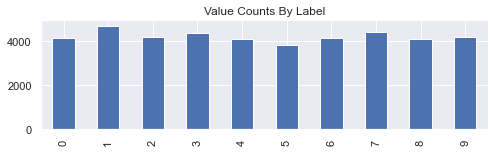

In [4]:
_ = df_train['label'].value_counts().sort_index().plot.bar(figsize=(8,2),title='Value Counts By Label')

# Prepare data for CNN

In [5]:
X_train, y_train = df_train.drop(labels=['label'], axis=1), df_train['label']
X_train, X_test = X_train/255, df_test/255
X_train, X_test = X_train.values.reshape(-1,28,28,1), X_test.values.reshape(-1,28,28,1)
y_train = utils.to_categorical(y_train, num_classes=10)

# Data augmentation via ImageDataGenerator

In [6]:
datagen = image.ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1
)

## Example for data augmentation

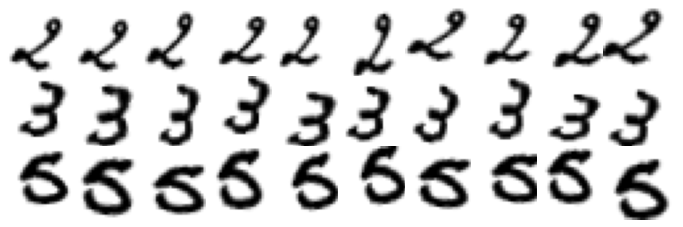

In [8]:
plt.figure(figsize=(12,4))
for i in range(30):
    plt.subplot(3,10,i+1)
    if i % 10 == 0:  
        digit = X_train[np.random.randint(X_train.shape[0])].reshape(1,28,28,1)        
    plt.imshow(datagen.flow(digit).next().reshape((28,28)), cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)    

# Build 15 CNNs

### Architectural highlights
![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/LeNet5.png)

The CNNs in this kernel follow [LeNet5's][1] design (pictured above) with the following improvements:  
* Two stacked 3x3 filters replace the single 5x5 filters. These become nonlinear 5x5 convolutions
* A convolution with stride 2 replaces pooling layers. These become learnable pooling layers.
* ReLU activation replaces sigmoid.
* Batch normalization is added
* Dropout is added
* More feature maps (channels) are added
* An ensemble of 15 CNNs with bagging is used  
  
Experiments [(here)][2] show that each of these changes improve classification accuracy.

[1]:http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
[2]:https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

In [9]:
def build_cnn():
    
    model = models.Sequential()

    model.add(layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [10]:
nets = 15

models_bag = []

for i in range(nets):
    models_bag.append(build_cnn())

In [11]:
annealer = callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [12]:
history = [0] * nets
epochs = 45

for j in range(nets):
    
    X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train, y_train, test_size = 0.1)
    
    history[j] = models_bag[j].fit(
        datagen.flow(X_train2, y_train2, batch_size=64),
        epochs = epochs, 
        steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,y_val2), 
        callbacks=[annealer], 
        verbose=0
    )
    
    print(
        "CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            j+1,
            epochs,
            max(history[j].history['accuracy']),
            max(history[j].history['val_accuracy']) 
        )
    )

CNN 1: Epochs=45, Train accuracy=0.99552, Validation accuracy=0.99595
CNN 2: Epochs=45, Train accuracy=0.99542, Validation accuracy=0.99595
CNN 3: Epochs=45, Train accuracy=0.99552, Validation accuracy=0.99595
CNN 4: Epochs=45, Train accuracy=0.99531, Validation accuracy=0.99714
CNN 5: Epochs=45, Train accuracy=0.99499, Validation accuracy=0.99690
CNN 6: Epochs=45, Train accuracy=0.99555, Validation accuracy=0.99762
CNN 7: Epochs=45, Train accuracy=0.99531, Validation accuracy=0.99619
CNN 8: Epochs=45, Train accuracy=0.99502, Validation accuracy=0.99667
CNN 9: Epochs=45, Train accuracy=0.99507, Validation accuracy=0.99595
CNN 10: Epochs=45, Train accuracy=0.99483, Validation accuracy=0.99500
CNN 11: Epochs=45, Train accuracy=0.99520, Validation accuracy=0.99690
CNN 12: Epochs=45, Train accuracy=0.99534, Validation accuracy=0.99714
CNN 13: Epochs=45, Train accuracy=0.99489, Validation accuracy=0.99524
CNN 14: Epochs=45, Train accuracy=0.99528, Validation accuracy=0.99810
CNN 15: Epochs=

# Ensemble 15 CNNs predictions and submit

In [13]:
results = np.zeros((X_test.shape[0],10))

for j in range(nets):
    results += models_bag[j].predict(X_test)

results = np.argmax(results, axis=1)
results = pd.Series(results, name='Label')

submission = pd.concat([pd.Series(range(1,28001), name='ImageId'), results], axis=1)
submission.to_csv('submission.csv', index=False)

875/875 [==============================] - 1s 2ms/step


# Preview Predictions

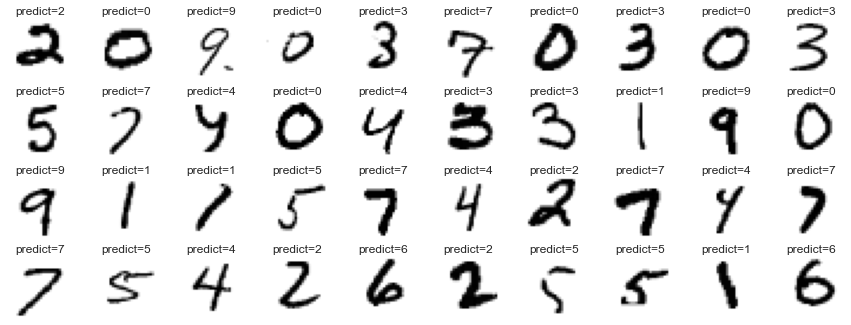

In [14]:
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

# Leaderboard Score

<img src="Leaderboard_score.png">